# Demo Notebook
This is a demo for Jupytext synchronization.

## Example: Compile Modelica Model to FMU, Simulate, and Plot Results

This example demonstrates how to:
1. Export `Modelica.Fluid.Examples.HeatingSystem` as a Co-Simulation FMU using OMPython.
2. Simulate the FMU using fmpy.
3. Plot sensor outputs (e.g., temperature) as a function of time.

In [1]:
import os
from typing import Any

import matplotlib.pyplot as plt
from fmpy import simulate_fmu
from OMPython import OMCSessionZMQ


def execute_omc_command(
    omc: OMCSessionZMQ,
    command: str,
    error_message: str = "",
    parsed: bool = True,
) -> Any:
    """
    Execute an OMC command and handle errors.

    Args:
        omc: OMCSessionZMQ instance
        command: Command to execute
        error_message: Custom error message to display if command fails

    Returns:
        The result of the command or raises RuntimeError if it fails
    """
    result = omc.sendExpression(command, parsed=parsed)
    if result is None:
        error = (
            omc.sendExpression("getErrorString()", parsed=False)
            or "No error details available"
        )
        full_error = (
            f"{error_message}\nError executing command: {command}\n{error}"
        )
        raise RuntimeError(full_error)
    return result


class ModelicaLoadError(Exception):
    """Raised when loading the Modelica library fails."""

    def __init__(
        self, message="Failed to ensure Modelica Standard Library is available"
    ):
        self.message = message
        super().__init__(self.message)


class FMUExportError(Exception):
    """Raised when FMU export fails."""

    pass


def ensure_modelica_library(omc, version="4.0.0"):
    """
    Ensure Modelica Standard Library is available, install if necessary.

    Args:
        omc: OMCSessionZMQ instance
        version: Modelica Standard Library version to install (default: "4.0.0")

    Returns:
        bool: True if library is available, raises exception on error
    """
    print(f"Checking for Modelica Standard Library version {version}...")

    # First, try to load the Modelica library
    try:
        result = execute_omc_command(
            omc,
            f'loadModel(Modelica,{{"{version}"}})',
            f"Failed to load Modelica Standard Library {version}",
        )
    except RuntimeError as e:
        print(
            f"Modelica Standard Library {version} not found. Attempting to install..."
        )
        print(f"Note: {str(e).split('\n')[0]}")
    else:
        print(f"Modelica Standard Library {version} loaded ({result}).")
        return True

    try:
        # Try to install the specific version using installPackage
        print(f"Installing Modelica Standard Library {version}...")
        execute_omc_command(
            omc,
            f'installPackage(Modelica, "{version}")',
            f"Failed to install Modelica Standard Library {version}",
        )

        print(f"Successfully installed Modelica Standard Library {version}")

        # Verify the installation by loading it
        try:
            execute_omc_command(
                omc,
                f'loadModel(Modelica,{{"{version}"}})',
                "Installation reported success but library failed to load",
            )
        except RuntimeError as load_error:
            print(
                f"Failed to load installed library: {str(load_error).split('\n')[0]}"
            )
            return False
        else:
            print("Modelica library loaded successfully after installation.")
            return True

    except RuntimeError as e:
        print(
            f"Failed to install Modelica Standard Library: {str(e).split('\n')[0]}"
        )
        print("Please install it manually or check your installation.")
        return False

In [2]:
omc = OMCSessionZMQ()
execute_omc_command(
    omc, 'cd("/workspaces/fmi-chroma/.generated")', "Failed to change directory"
)

'/workspaces/fmi-chroma/.generated'

In [3]:
# Settings
model_name = "Modelica.Fluid.Examples.HeatingSystem"
model_name = "Modelica.Fluid.Examples.PumpingSystem"
model_name = "Modelica.Blocks.Examples.PID_Controller"
fmu_filename = (
    f"/workspaces/fmi-chroma/.generated/{model_name.split('.')[-1]}.fmu"
)

# Step 1: Export the Modelica model as a Co-Simulation FMU
if not os.path.exists(fmu_filename):
    print(f"Exporting {model_name} to {fmu_filename} ...")

    # Ensure Modelica Standard Library 4.0.0 is available
    if not ensure_modelica_library(omc, version="4.0.0"):
        raise ModelicaLoadError()

    # Build the FMU
    try:
        fmu_filename = execute_omc_command(
            omc,
            f'buildModelFMU({model_name}, version="2.0", fmuType="cs")',
            f"Failed to export {model_name} as an FMU",
        )
        print(f"FMU exported: {fmu_filename}")
    except RuntimeError as e:
        raise FMUExportError(str(e)) from e
else:
    print(f"FMU already exists: {fmu_filename}")

FMU already exists: /workspaces/fmi-chroma/.generated/PID_Controller.fmu


Simulating the FMU ...
Available variables: ('time', 'PI.I.y', 'inertia1.phi', 'inertia2.w', 'integrator.y', 'spring.phi_rel')


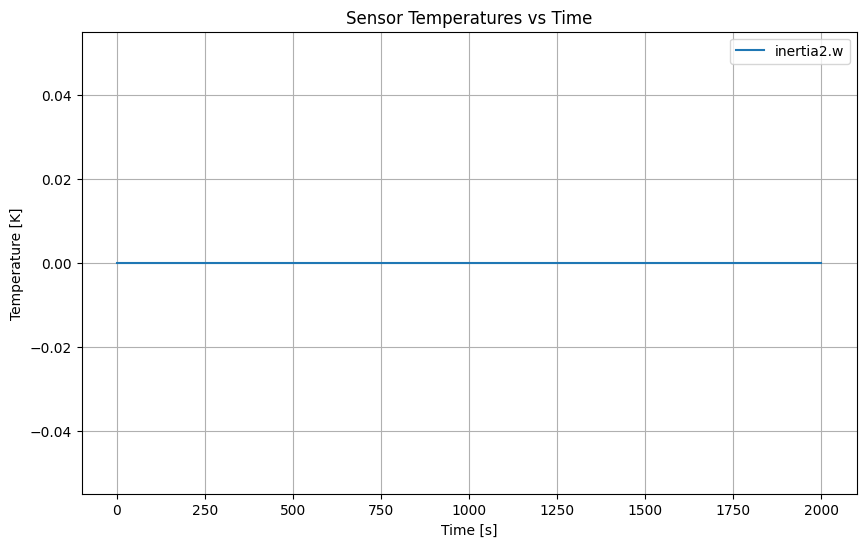

In [4]:
# Step 2: Simulate the FMU using fmpy
print("Simulating the FMU ...")
result = simulate_fmu(fmu_filename, start_time=0, stop_time=2000)

# Step 3: Plot results
# List available variables
print("Available variables:", result.dtype.names)

# Example: Plot temperatures of two sensors as a function of time
plt.figure(figsize=(10, 6))
plt.plot(result["time"], result["inertia2.w"], label="inertia2.w")

plt.xlabel("Time [s]")
plt.ylabel("Temperature [K]")
plt.title("Sensor Temperatures vs Time")
plt.legend()
plt.grid(True)
plt.show()

# Note: Variable names may differ depending on the FMU structure. Use the print above to inspect them.